In [28]:
# !pip install torch torchvision
# !pip install Pillow

In [29]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())


2.5.1
0.20.1
11.8
CUDA available: True


In [30]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
%matplotlib inline

In [31]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

c:\hp\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\hp\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [34]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU found or CUDA not installed properly.")


PyTorch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU: NVIDIA GeForce MX250


In [35]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [36]:
def load_image(img_path, max_size = 400, shape= None):
                image = Image.open(img_path).convert('RGB')
                if max(image.size) > max_size:
                    size = max_size
                else:
                    size = max(image.size)
    
                if shape is not None:
                    size = shape
                in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

                image = in_transform(image).unsqueeze(0)
    
                return image

In [37]:
content = load_image('D:\\PranitCode\\Projects\\CV\\STYLE TRANSFER\\2.jpg').to(device)
style = load_image('D:\\PranitCode\\Projects\\CV\\STYLE TRANSFER\\1.jpg').to(device)

In [38]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

(-0.5, 490.5, 338.5, -0.5)

In [46]:
def get_features(image, model):

    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
    
    features = {}

    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image

    return features

In [47]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [48]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [50]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [51]:
target = content.clone().requires_grad_(True).to(device)

In [52]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  4930060.0
Iteration:  300


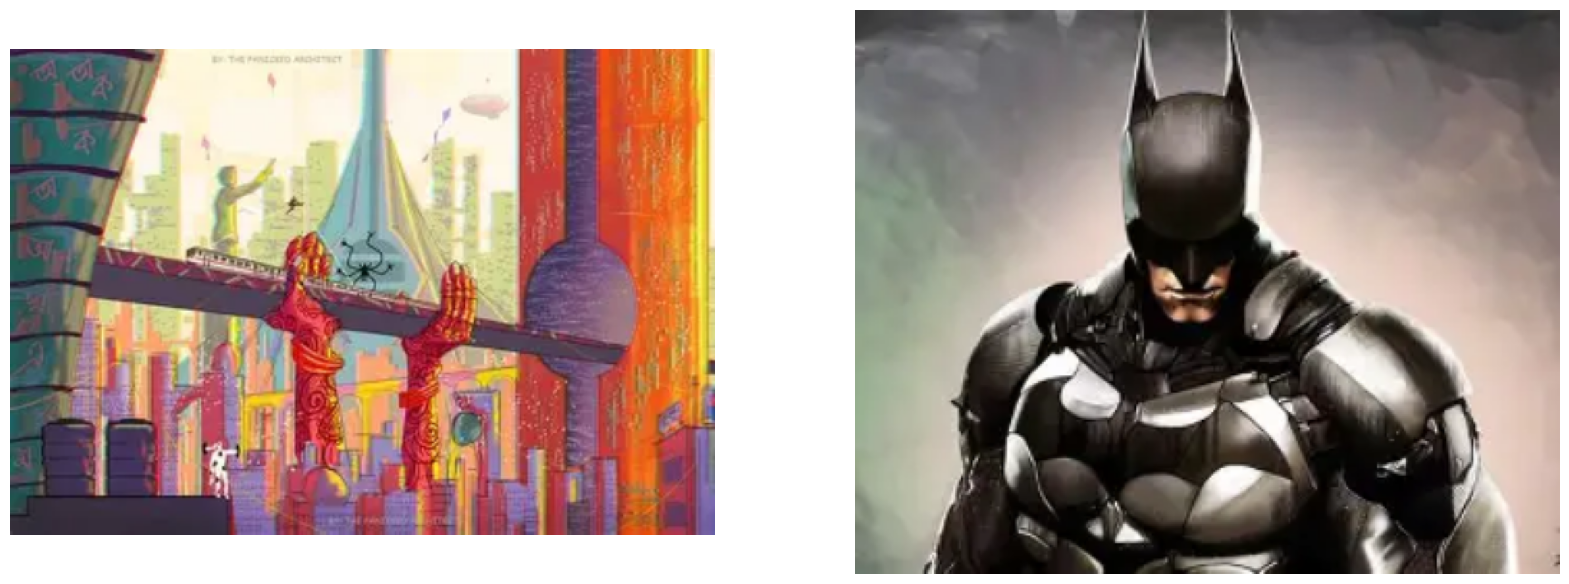

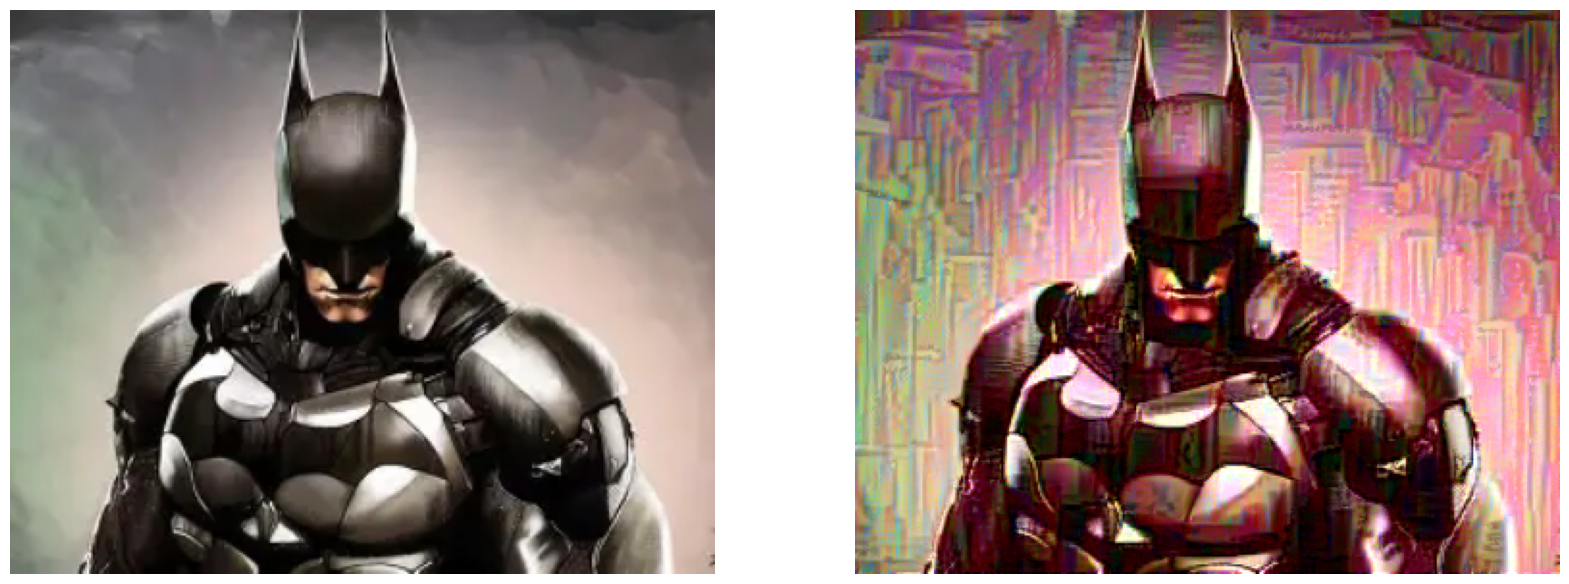

Total loss:  2742694.75
Iteration:  600


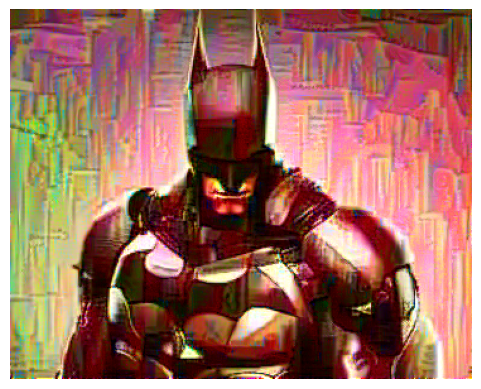

Total loss:  2158260.25
Iteration:  900


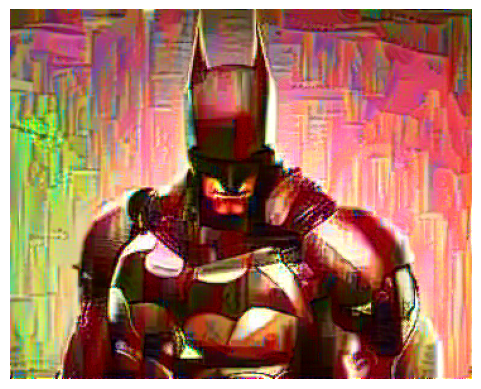

Total loss:  1868463.625
Iteration:  1200


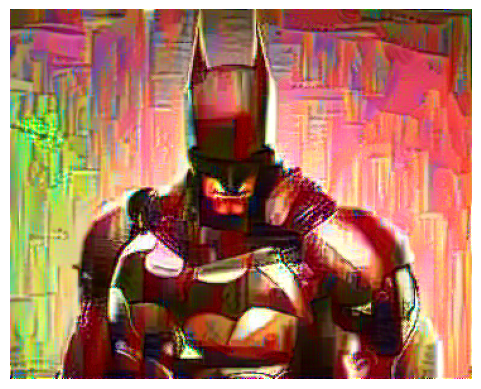

Total loss:  1655637.0
Iteration:  1500


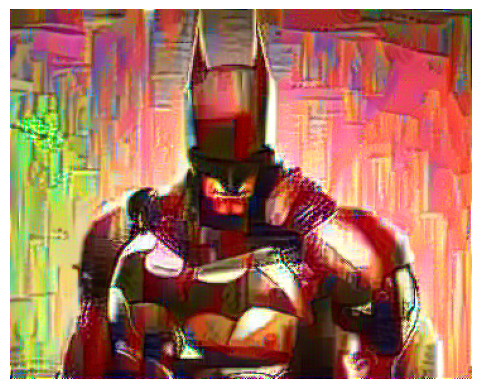

Total loss:  1475271.625
Iteration:  1800


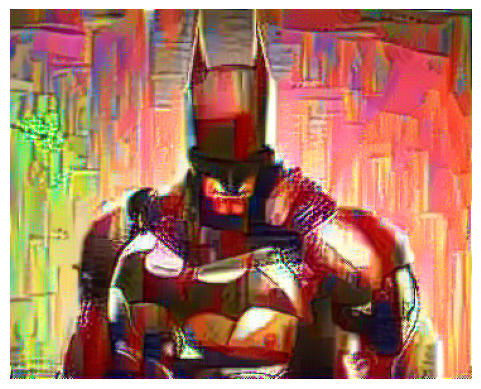

Total loss:  1319099.875
Iteration:  2100


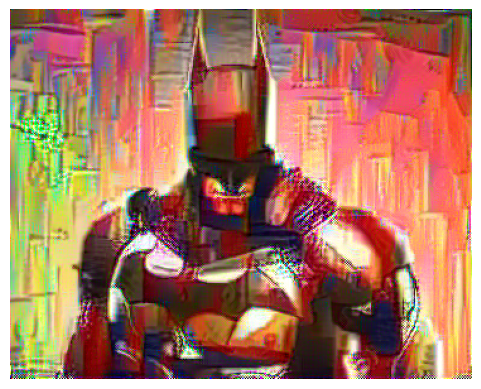

In [53]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

(-0.5, 365.5, 292.5, -0.5)

In [55]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [57]:
!dir

 Volume in drive D is DATA
 Volume Serial Number is 1AC7-7409

 Directory of d:\PranitCode\Projects\CV\STYLE TRANSFER

09/08/2025  20:41    <DIR>          .
03/08/2025  12:41    <DIR>          ..
08/08/2025  23:21            16,224 1.jpg
08/08/2025  23:23             7,970 2.jpg
08/08/2025  23:15           451,006 CV1.avif
08/08/2025  23:18         1,073,673 CV2.avif
09/08/2025  20:41         1,190,954 output.mp4
08/08/2025  23:26             8,768 Untitled-1.ipynb
               6 File(s)      2,748,595 bytes
               2 Dir(s)  267,028,742,144 bytes free
